In [1]:
import os
import markdown
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from pandarallel import pandarallel
from IPython.display import display

In [2]:
pandarallel.initialize(progress_bar=True, nb_workers=8)
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
df = pd.read_csv(os.path.join("predict-closed-questions-on-stack-overflow", "train.csv"), index_col="PostId")

In [4]:
df = df.sample(10_000)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2308720 to 2600876
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   PostCreationDate                     10000 non-null  object
 1   OwnerUserId                          10000 non-null  int64 
 2   OwnerCreationDate                    10000 non-null  object
 3   ReputationAtPostCreation             10000 non-null  int64 
 4   OwnerUndeletedAnswerCountAtPostTime  10000 non-null  int64 
 5   Title                                10000 non-null  object
 6   BodyMarkdown                         10000 non-null  object
 7   Tag1                                 9999 non-null   object
 8   Tag2                                 8465 non-null   object
 9   Tag3                                 5857 non-null   object
 10  Tag4                                 3055 non-null   object
 11  Tag5                             

In [6]:
df.head()

,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
PostId,,,,,,,,,,,,,,
2308720,02/22/2010 04:03:46,276620,02/19/2010 01:32:46,1,2,My intent putExtra into two different names wi...,I have two names which suppose to get two diff...,android,NaN,NaN,NaN,NaN,NaN,open
10842943,06/01/2012 00:19:14,1189616,02/04/2012 17:00:19,91,4,Android SQLite Database(3300): sqlite returned...,"I'm starting to go a little mad ha ha, I have ...",android,database,sqlite,NaN,NaN,NaN,open
1164118,07/22/2009 09:32:56,93571,04/21/2009 03:50:23,1,0,Cookie Security of Pops Up Window,I have been to some css/html/js discussing boa...,javascript,security,NaN,NaN,NaN,NaN,open
1534768,10/07/2009 23:25:41,186016,10/07/2009 23:25:41,1,0,PHP Ranking System Array Sort,I develop a ranking system. I got the followin...,php,sorting,ranking,NaN,NaN,NaN,open
5581367,04/07/2011 12:53:50,671533,03/22/2011 15:51:25,146,15,Margin-Top difference from Chrome to Other Bro...,I am working on a WordPress theme using the Wo...,wordpress,html5,css3,NaN,NaN,NaN,open


In [7]:
df["PostCreationDate"] = pd.to_datetime(df["PostCreationDate"])
df["OwnerCreationDate"] = pd.to_datetime(df["OwnerCreationDate"])

In [8]:
df.drop(columns=["PostClosedDate", "OwnerUserId"], inplace=True)

In [9]:
df["TimeDiffSinceRegistration"] = df["PostCreationDate"] - df["OwnerCreationDate"]

In [10]:
df.drop(columns=["PostCreationDate", "OwnerCreationDate"], inplace=True)

In [11]:
df["Closed"] = df["OpenStatus"] != "open"

In [12]:
df["NumTags"] = df[["Tag1", "Tag2", "Tag3", "Tag4", "Tag5"]].notnull().sum(axis=1)

In [13]:
def md_to_text(md):
    html = markdown.markdown(str(md))
    soup = BeautifulSoup(html, features='html.parser')
    return soup.get_text()

def safe_md_to_text(md):
    try:
        return md_to_text(md)
    except Exception as e:
        return md

In [14]:
df["BodyText"] = df["BodyMarkdown"].parallel_apply(safe_md_to_text)

In [15]:
df.drop(columns=["BodyMarkdown"], inplace=True)

In [16]:
df["TitleLength"] = df["Title"].str.len()
df["BodyTextLength"] = df["BodyText"].str.len()

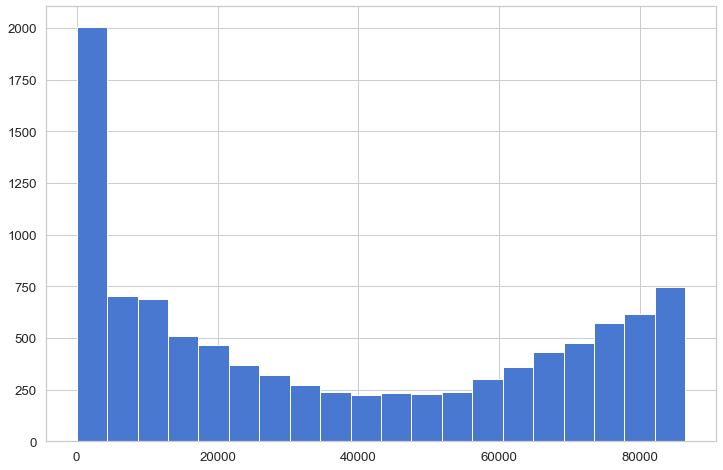

In [17]:
df["TimeDiffSinceRegistration"].dt.seconds.hist(bins=20);

<AxesSubplot:>

False    0.9779
True     0.0221
Name: Closed, dtype: float64

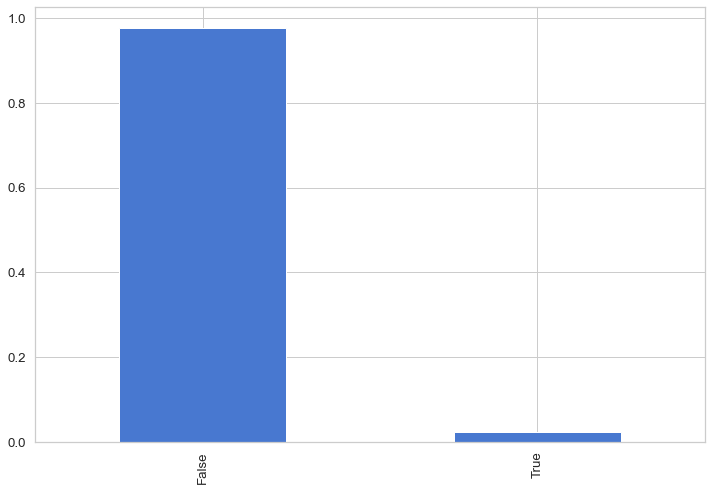

In [18]:
counts = df["Closed"].value_counts(normalize=True)
display(counts.plot.bar())
counts

<AxesSubplot:>

open                   0.9779
not a real question    0.0094
not constructive       0.0052
off topic              0.0043
too localized          0.0032
Name: OpenStatus, dtype: float64

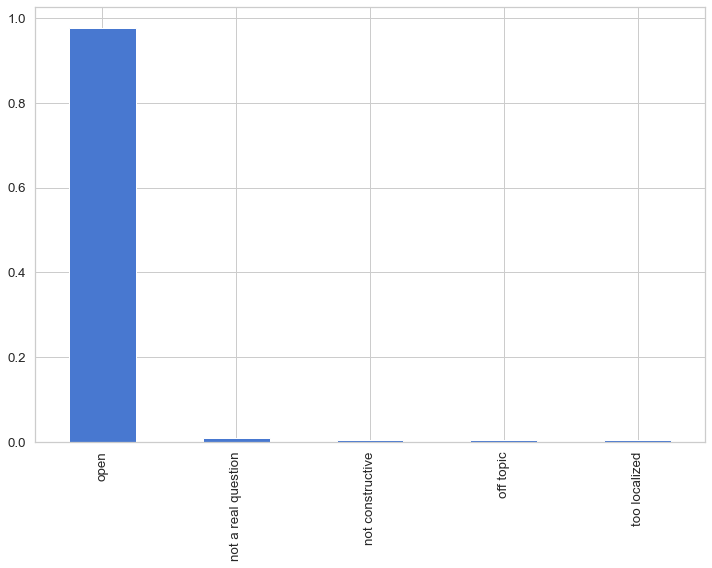

In [25]:
counts = df["OpenStatus"].value_counts(normalize=True)
display(counts.plot.bar())
counts

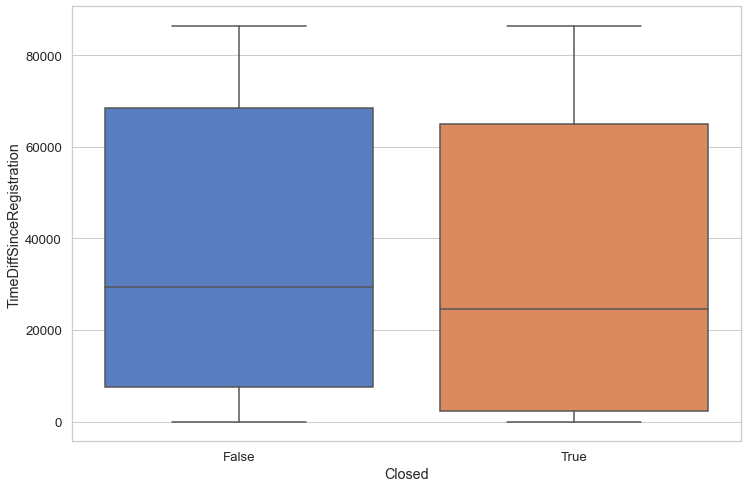

In [19]:
sns.boxplot(data=df, x="Closed", y=df["TimeDiffSinceRegistration"].dt.seconds);

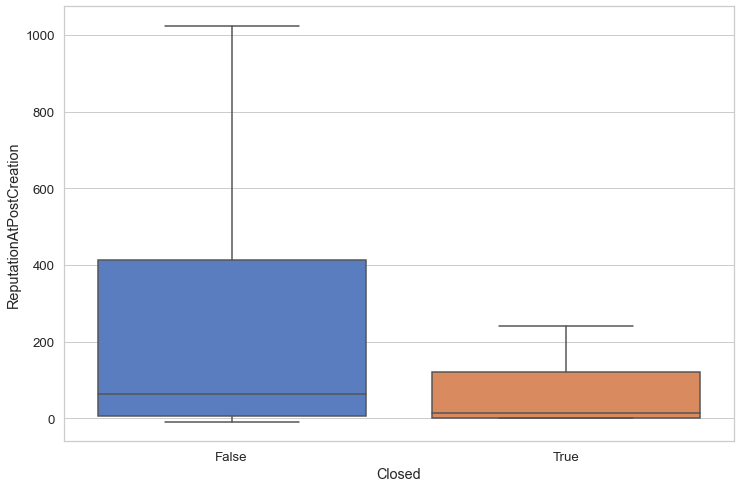

In [20]:
sns.boxplot(data=df, x="Closed", y="ReputationAtPostCreation", showfliers=False);

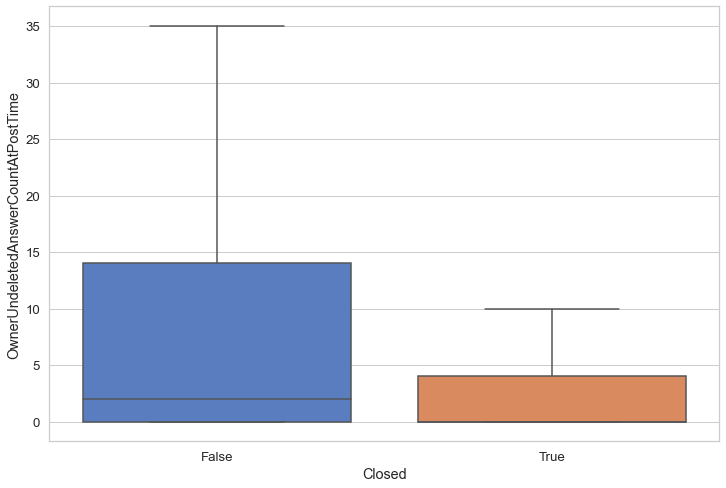

In [21]:
sns.boxplot(data=df, x="Closed", y="OwnerUndeletedAnswerCountAtPostTime", showfliers=False);

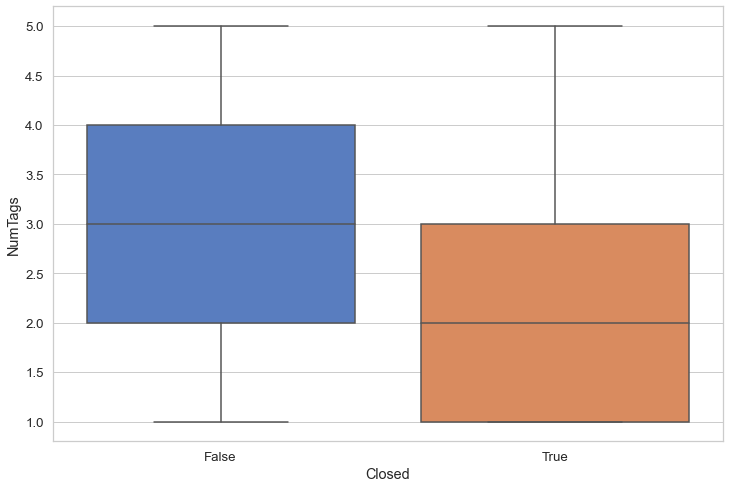

In [22]:
sns.boxplot(data=df, x="Closed", y="NumTags");

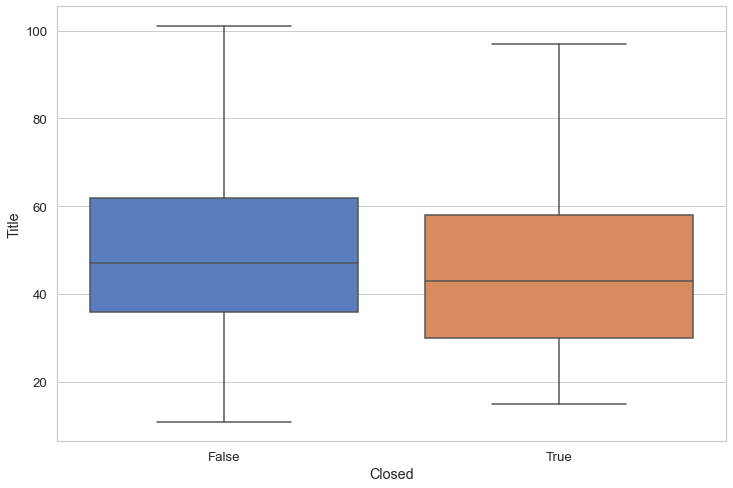

In [23]:
sns.boxplot(data=df, x="Closed", y=df["Title"].str.len(), showfliers=False);

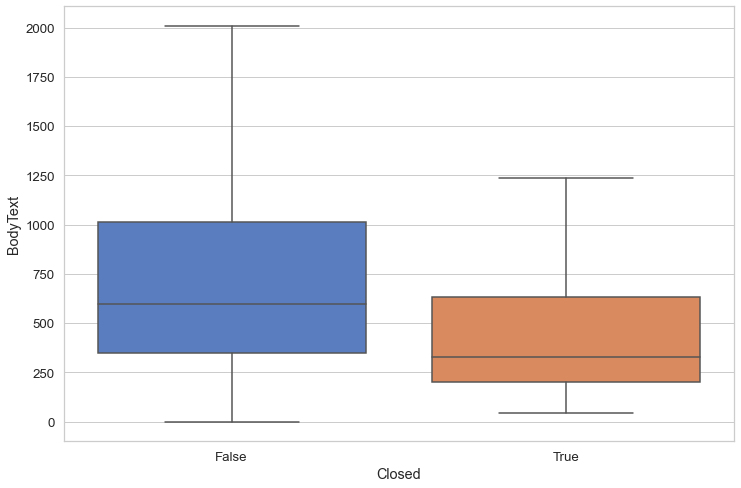

In [24]:
sns.boxplot(data=df, x="Closed", y=df["BodyText"].str.len(), showfliers=False);

In [27]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [28]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [36]:
token_lens = []

for txt in df["BodyText"]:
    tokens = tokenizer.encode(txt, max_length=1000)
    token_lens.append(len(tokens))


/Users/rubens/.local/share/virtualenvs/kaggle-stackoverflow-t5Rcp3VJ/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

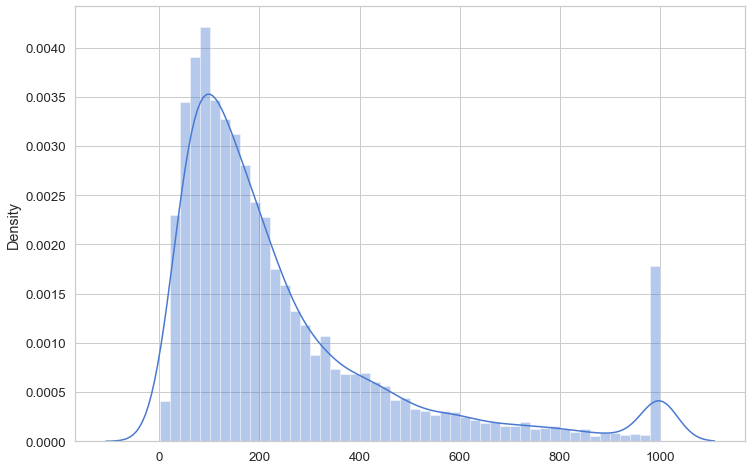

In [37]:
sns.distplot(token_lens)
